### Pedro Jorge Oliveira Câmara - Álgebra Linear Aplicada - Autoencoders

In [1]:
import numpy as np
from numpy.linalg import *

import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.optim as optim

from typing import *

# para passar as instâncias do pytorch para a GPU caso tenha uma 
# (no meu caso tem)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Funções auxiliares 

In [2]:
def plot_signal(sample_points: np.ndarray, signals: np.ndarray, label: str = "Sinais com ruído", color=None) -> None:
    """
    Plota um conjunto de sinais.

    Args:
        sample_points (np.ndarray): lista de pontos do domínio
        signals (np.ndarray): matriz ou vetor de sinais com amostragens para os valores do sinal em cada ponto
        label (str, optional): Título do plot. Defaults to "Sinais com ruído".
    """
    plt.plot(sample_points, signals)
    plt.title(label)
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")
    plt.show()
    

def plot_signal_comparison(sample_points: np.ndarray, signals: dict, label: str, colors = List) -> None:
    for signal_name, color in zip(signals.keys(), colors):
        plt.plot(sample_points, signals[signal_name], label=signal_name, color = color)
    
    plt.title(label)
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [3]:
def get_f(m: float = 0, s: float = 1.5):
    """
    Retorna aleatoriamente uma função `f` trigonométrica ou combinadas de funções trigonométricas.
    Para gerar mais variações nos sinais, as funções causam uma perturbação na entrada. Por exemplo: sin(x*0.4), cos(x*(-0.2)). 
    A perturbação é dada por uma amostra de uma distribuição normal de média `m` e desvio padrão `s`, gerada a cada vez que uma função é retornada.

    Returns:
        Callable: uma função f 
    """
    r = np.random.normal
    
    functions = (
        lambda x: np.sin(x*r(m, s)),
        lambda x: np.cos(x*r(m, s)),
        lambda x: np.sin(x*r(m, s)) + np.cos(x*r(m, s)),
        lambda x: np.sin(x*r(m, s)) - np.cos(x*r(m, s)),
        lambda x: np.sin(x*r(m, s)) * np.cos(x*r(m, s)),
    )
    
    f = np.random.choice(functions)
    
    return f

In [4]:
def add_noise(signals: np.ndarray, level: float = 0.1, mean: float = 0, std: float = 1) -> float:
    """
    Adiciona ruído a um sinal. O ruído é uma amostra de uma distribuição normal de média `mean` e desvio padrão `std`.

    Args:
        signal_vector (np.ndarray): vetor ou matrix em que será adicionado o ruído
        level (float, optional): nível do ruído. Defaults to 1.
        mean (float, optional): média da distribuição normal. Defaults to 0.
        std (float, optional): desvio padrão da distribuição normal. Defaults to 1.

    Returns:
        float: _description_
    """
    return signals + (np.random.normal(mean, std, size=signals.shape) * level)


def generate_signal_vector(f: Callable, sample_points: np.ndarray) -> np.ndarray:
    """
    Gera um vetor de sinais. Cada idx é um "instante de tempo" e cada v[idx] é o valor correspondente do sinal.

    Args:
        f (Callable): função para aplicar aos pontos
        sample_points (np.ndarray): domínio da amostra

    Returns:
        np.ndarray: vetor de sinais 
    """
    return f(sample_points)
    
    
def generate_signal_matrix(n_signals: int,  sample_points: np.ndarray) -> np.ndarray:
    """
    Gera uma matriz de sinais. Cada linha é um vetor de sinais.
    Dada uma linha L, cada idx é um "instante de tempo" e cada L[idx] é o valor correspondente do sinal.

    Args:
        n_signals (int): número de sinais a serem amostrados. (número de linhas da matriz)
        sample_points (np.ndarray): domínio da amostra

    Returns:
        np.ndarray: matriz de sinais
    """
    n_points = sample_points.size
    
    m = np.zeros((n_signals, n_points))
    for i in range(n_signals):
        f = get_f()
        m[i, :] = generate_signal_vector(f, sample_points)
    
    return m


def generate_sample_points(start: float, stop: float, step: float) -> np.ndarray:
    """
    Gera o domínio da amostra

    Args:
        start (float): menor valor do domínio
        stop (float): maior valor do domínio
        step (float): tamanho do passo entre o menor e o maior valor

    Returns:
        np.ndarray: amostra de pontos no intervalo [`start`, `stop`) com passo `step`
    """
    return np.arange(start, stop, step)

### Definição do Autoencoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, activation: Callable):
        """
        Args:
            activation (Callable): função de ativação
        """
        super(Autoencoder, self).__init__()
        self.activation_name = activation.__name__
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 50),
            activation(),
            nn.Linear(50, 25),
            activation(),
            nn.Linear(25, 10),
            activation(),
            nn.Linear(10, 5),
            #activation(),
            #nn.Linear(5, 1),
            #activation()
        )
        
        self.decoder = nn.Sequential(
            #nn.Linear(1, 5),
            #activation(),
            nn.Linear(5, 10),
            activation(),
            nn.Linear(10, 25),
            activation(),
            nn.Linear(25, 50),
            activation(),
            nn.Linear(50, 100)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def reconstruct(self, signals):
        signals = torch.tensor(signals, dtype=torch.float32).to(device)
        self.eval()
        with torch.no_grad():
            return self.forward(signals).detach().cpu().numpy()

### Instanciação e treinamento do Autoencoder

In [6]:
def train(signals_np: np.ndarray, n_epochs: int, activation, lr):
    activation = activation 
    lr = lr 
    
    autoencoder = Autoencoder(activation = activation).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    signals = torch.tensor(signals_np, dtype=torch.float32).to(device)
    
    for epoch in range(n_epochs):
        outputs = autoencoder(signals)
        loss = criterion(outputs, signals)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

    return autoencoder

In [7]:
start = 0
stop = 10
step = 0.1

n_samples = 20000
n_epochs = 10000

sample_points = generate_sample_points(start, stop, step)
signals_matrix = generate_signal_matrix(n_samples, sample_points)

U, S, V = np.linalg.svd(signals_matrix.T)

In [8]:
params = dict(activation = None, lr = 0.005) 

activations = (nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU, nn.PReLU, nn.GELU, nn.Identity)
autoencoders = []

for activation in activations:
    params["activation"] = activation
    autoencoders.append(train(signals_matrix, n_epochs, **params))

Epoch [100/10000], Loss: 0.3134
Epoch [200/10000], Loss: 0.2182
Epoch [300/10000], Loss: 0.1769
Epoch [400/10000], Loss: 0.1583
Epoch [500/10000], Loss: 0.1427
Epoch [600/10000], Loss: 0.1361
Epoch [700/10000], Loss: 0.1321
Epoch [800/10000], Loss: 0.1284
Epoch [900/10000], Loss: 0.1246
Epoch [1000/10000], Loss: 0.1228
Epoch [1100/10000], Loss: 0.1197
Epoch [1200/10000], Loss: 0.1183
Epoch [1300/10000], Loss: 0.1159
Epoch [1400/10000], Loss: 0.1159
Epoch [1500/10000], Loss: 0.1142
Epoch [1600/10000], Loss: 0.1126
Epoch [1700/10000], Loss: 0.1125
Epoch [1800/10000], Loss: 0.1130
Epoch [1900/10000], Loss: 0.1110
Epoch [2000/10000], Loss: 0.1101
Epoch [2100/10000], Loss: 0.1092
Epoch [2200/10000], Loss: 0.1095
Epoch [2300/10000], Loss: 0.1087
Epoch [2400/10000], Loss: 0.1083
Epoch [2500/10000], Loss: 0.1071
Epoch [2600/10000], Loss: 0.1069
Epoch [2700/10000], Loss: 0.1062
Epoch [2800/10000], Loss: 0.1060
Epoch [2900/10000], Loss: 0.1057
Epoch [3000/10000], Loss: 0.1043
Epoch [3100/10000],

### Singular Value Decomposition

In [9]:
def svd_reconstruction(U, S, V, signal, n_components: int) -> torch.Tensor:
    """
    Reconstrói uma matriz até o posto `n_components`.

    Args:
        U (np.ndarray): matriz U do SVD
        S (np.ndarray): matriz S do SVD
        V (np.ndarray): matriz V do SVD
        n_components (int): posto da matriz reconstruída

    Returns:
        np.ndarray: matriz original reconstruída com posto igual a n_components
    """
    U = U[:, :n_components]
    S = np.diag(S[:n_components])
    V = V[:n_components, :]
    
    return U @ (U.T @ signal.T)

### Experimentos

In [10]:
def generate_noisy_signal_matrix(f: Callable, n_signals: int,  sample_points: np.ndarray, noisy = True) -> np.ndarray:
    """
    Gera uma matriz de sinais. Cada linha é um vetor de sinais.
    Dada uma linha L, cada idx é um "instante de tempo" e cada L[idx] é o valor correspondente do sinal.

    Args:
        n_signals (int): número de sinais a serem amostrados. (número de linhas da matriz)
        sample_points (np.ndarray): domínio da amostra

    Returns:
        np.ndarray: matriz de sinais
    """
    n_points = sample_points.size
    
    m = np.zeros((n_signals, n_points))
    for i in range(n_signals):
        m[i, :] = generate_signal_vector(f, sample_points)
        if noisy:
            m[i, :] = add_noise(m[i, :], level = 1)
    
    return m

In [11]:
def plot_svd_experiments(sample_points, noisy_signals, clean_signals, rank, signal_label):
    plot_signal(sample_points, noisy_signals.T, f"{signal_label} com ruído")
    
    reconstruction = svd_reconstruction(U, S, V, noisy_signals, rank)
    
    plot_signal(sample_points, reconstruction, f"{signal_label} reconstruído - SVD posto {rank}")
    plot_signal(sample_points, reconstruction.T.mean(axis=0), f"{signal_label} reconstruído - SVD posto {rank}")
    
    signals = dict(Original = clean_signals.T, Reconstrução = reconstruction.T.mean(axis=0))
    plot_signal_comparison(sample_points, signals, label = f"{signal_label} reconstruído - SVD posto {rank}", colors = ["red", "blue"])
    
    
def plot_autoencoder_experiments(autoencoder, sample_points, noisy_signals, clean_signals, dimension, signal_label):
    #plot_signal(sample_points, noisy_signals.T, f"{signal_label} com ruído")

    reconstruction = autoencoder.reconstruct(noisy_signals)

    plot_signal(sample_points, reconstruction.T, f"{signal_label} reconstruído - Autoencoder - Espaço latente {dimension}d - Ativação: {autoencoder.activation_name}")
    plot_signal(sample_points, reconstruction.mean(axis=0), f"{signal_label} reconstruído - Autoencoder - Espaço latente {dimension}d - Ativação: {autoencoder.activation_name}")

    signals = dict(Original = clean_signals.T, Reconstrução = reconstruction.mean(axis=0))
    plot_signal_comparison(sample_points, signals, label = f"{signal_label} reconstruído - Autoencoder - Espaço latente {dimension}d - Ativação: {autoencoder.activation_name}", colors = ["red", "blue"])


In [12]:
n_signals = 10

f = lambda x: np.sin(x)

sin_clean = generate_noisy_signal_matrix(f, 1, sample_points, noisy = False)
sin = generate_noisy_signal_matrix(f, n_signals, sample_points)

label = "Sin"

### Plots

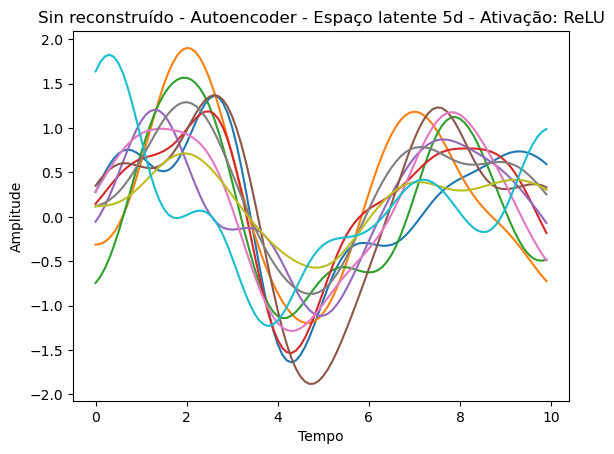

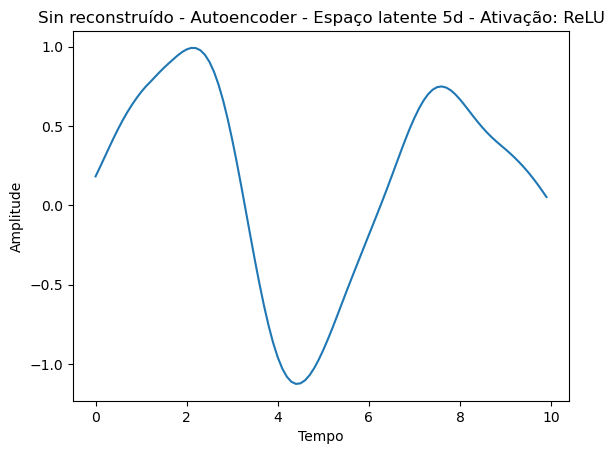

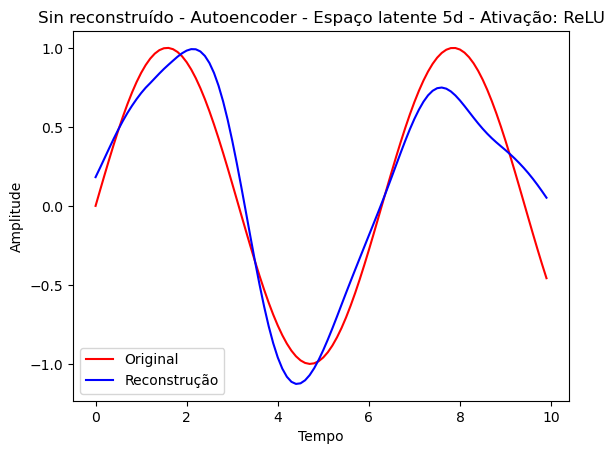

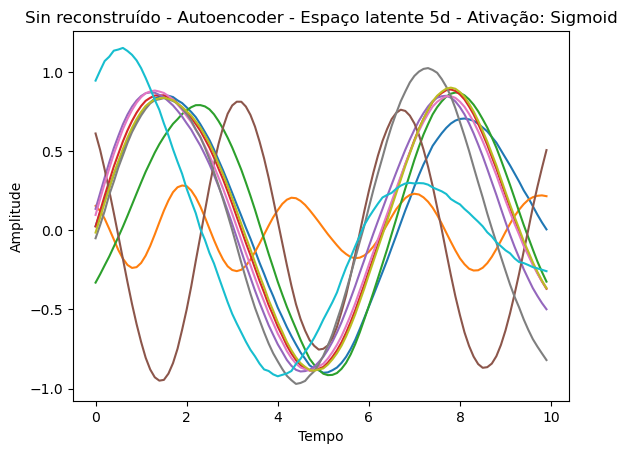

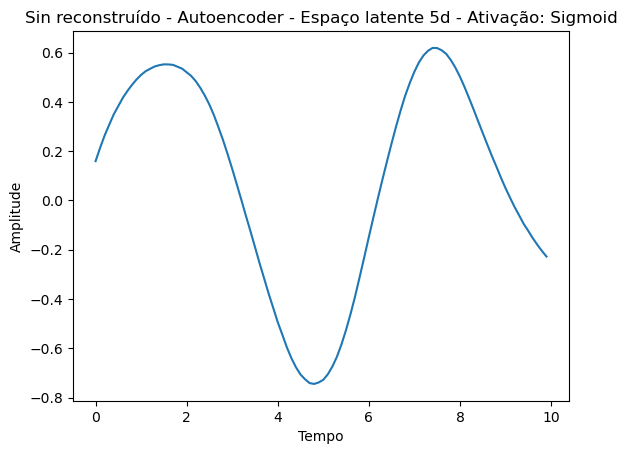

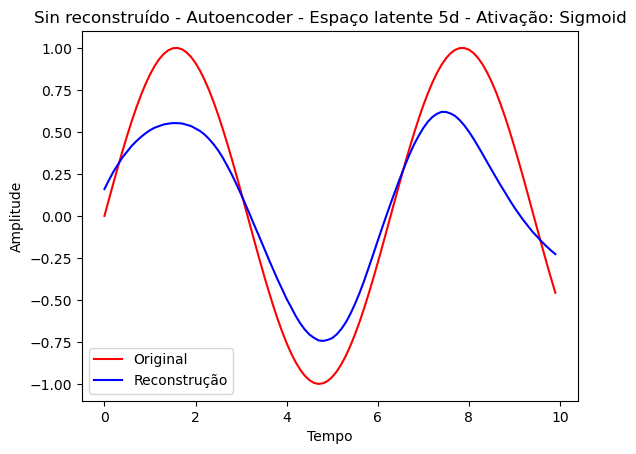

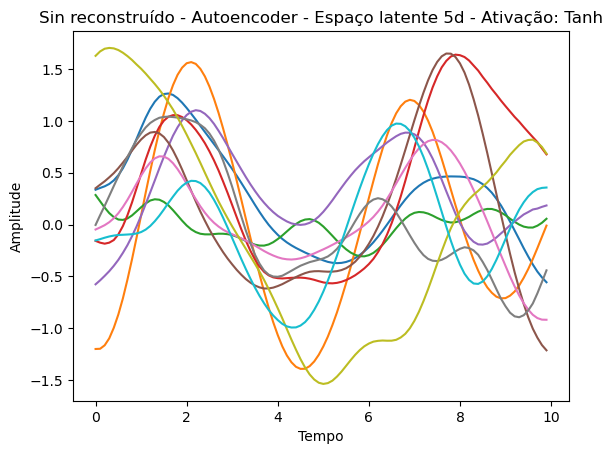

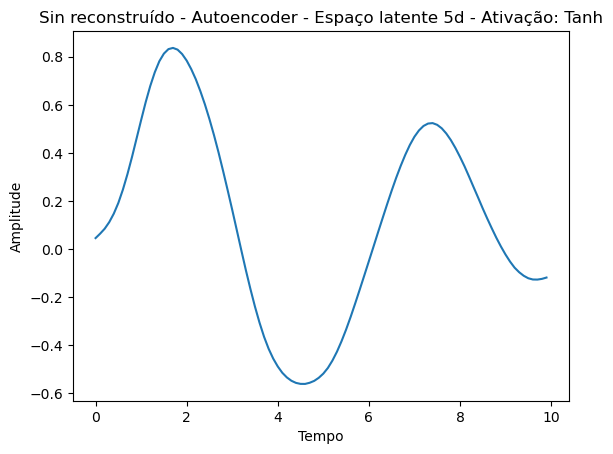

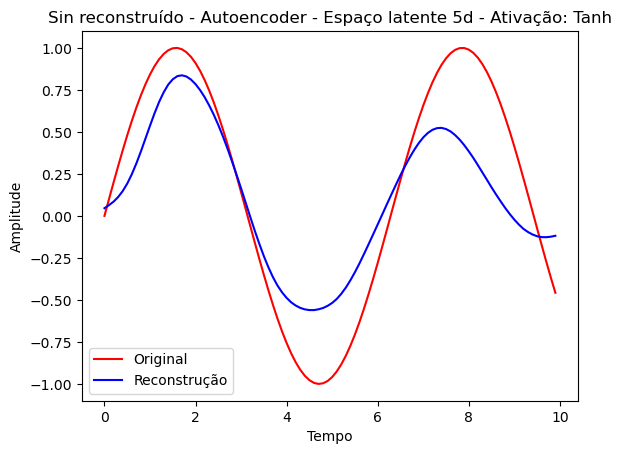

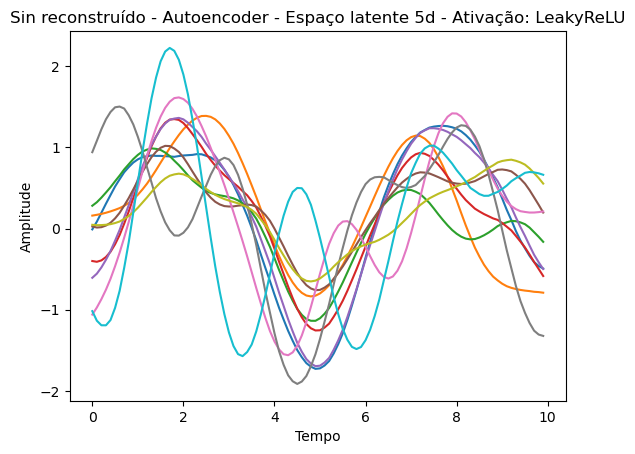

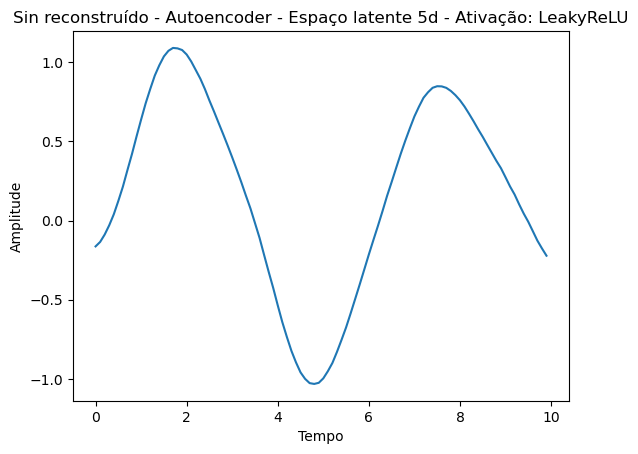

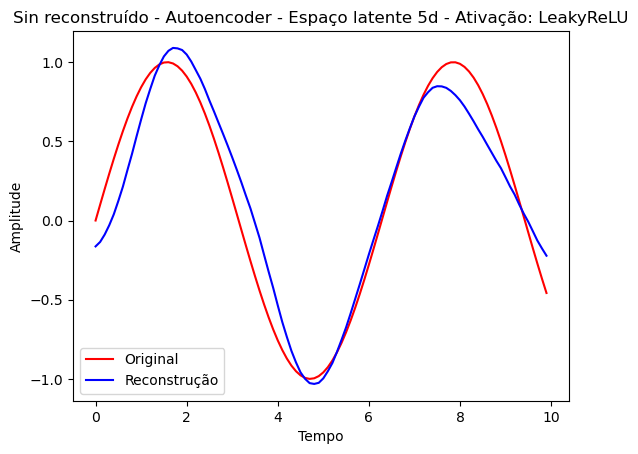

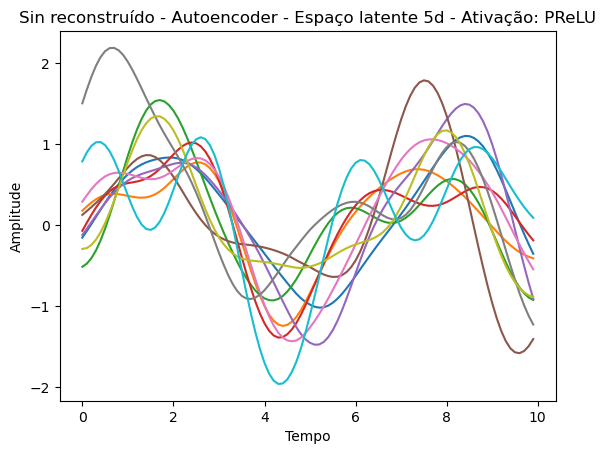

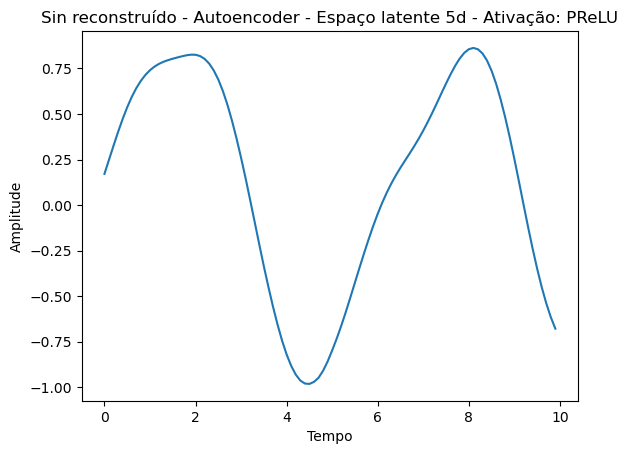

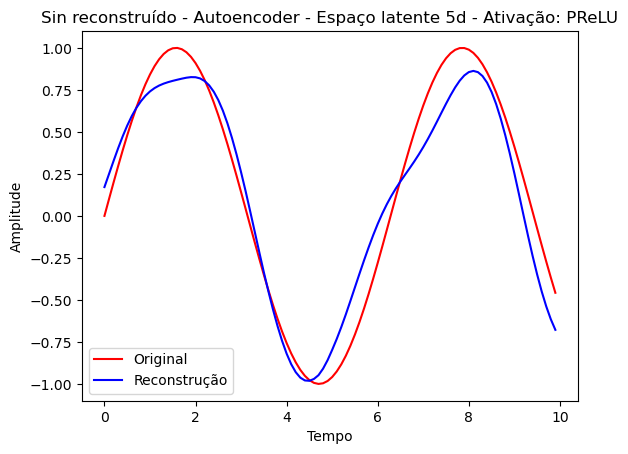

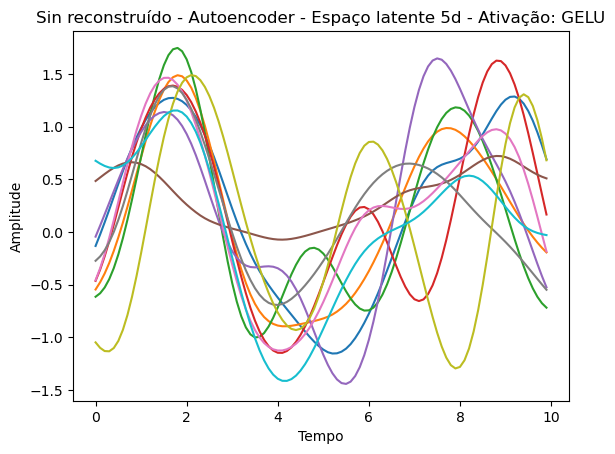

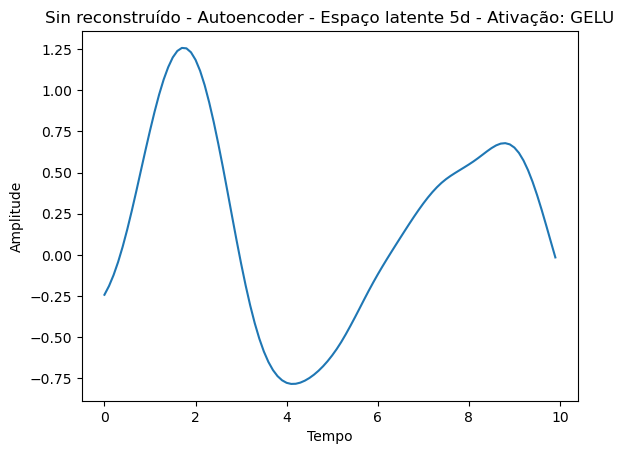

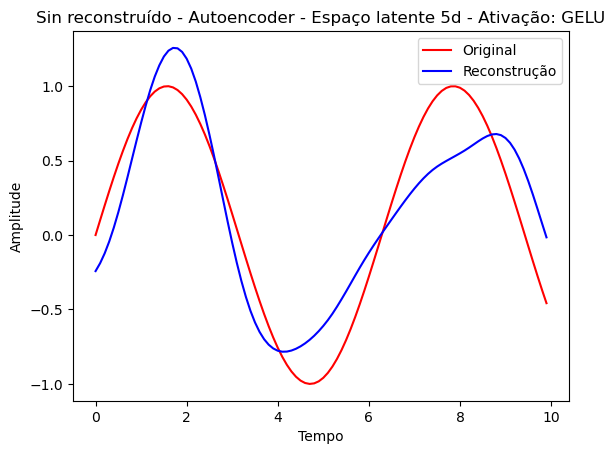

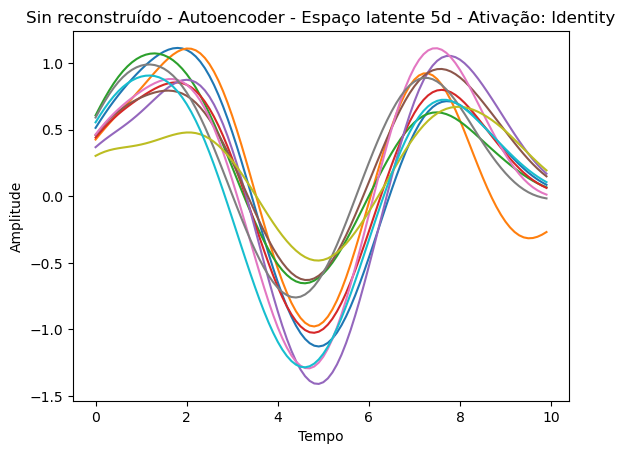

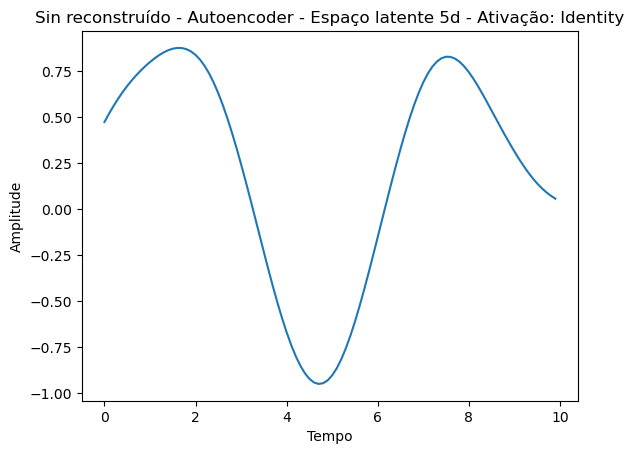

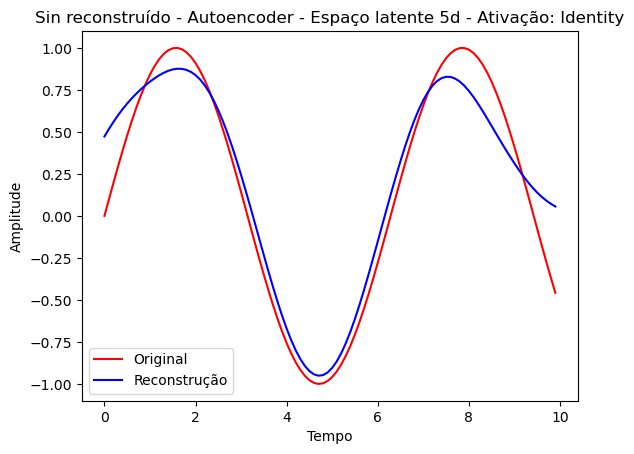

In [13]:
dimension = 5

for autoencoder in autoencoders:
    plot_autoencoder_experiments(autoencoder, sample_points, sin, sin_clean, dimension, label)

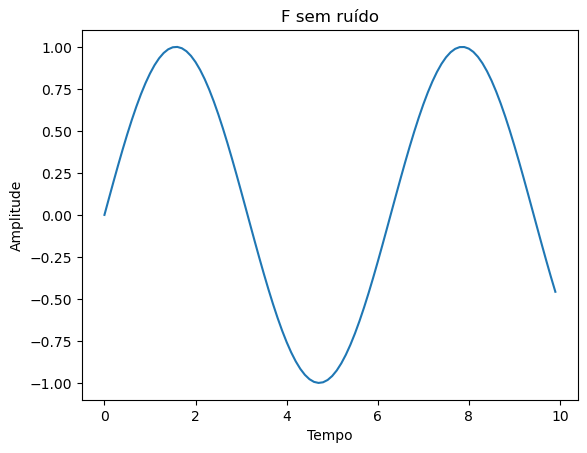

In [14]:
plot_signal(sample_points, sin_clean.T, "F sem ruído")

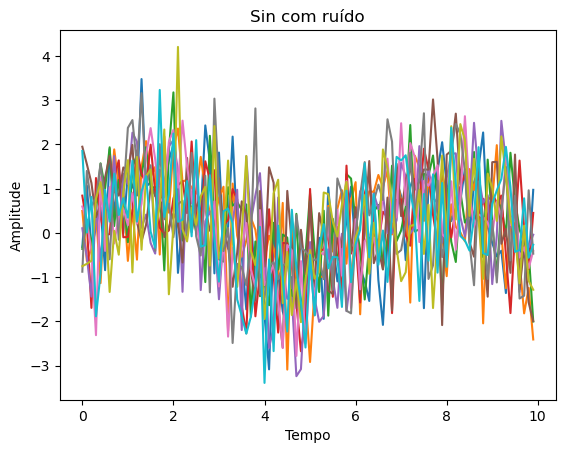

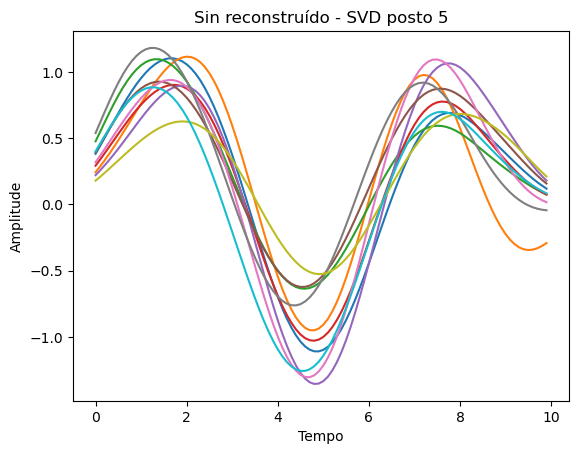

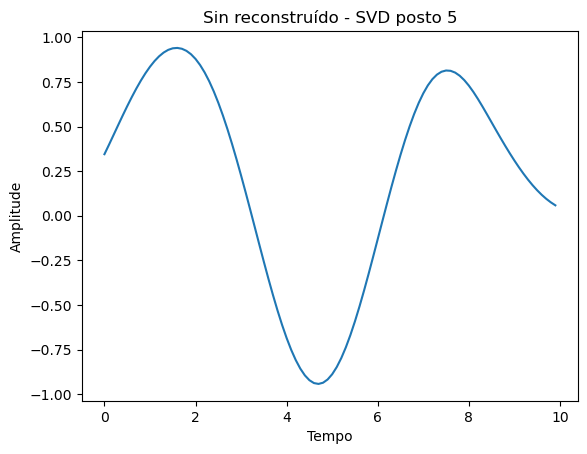

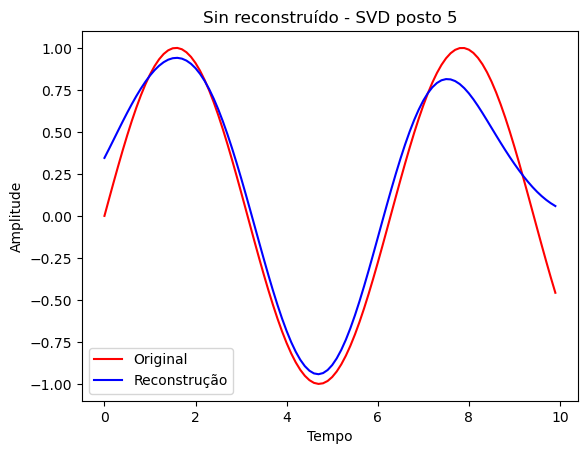

In [15]:
plot_svd_experiments(sample_points, sin, sin_clean, dimension, label)